# Limpieza de datos

Vamos a aplicar el [checklist del Banco Mundial](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning) en Python usando el [SciPy stack](https://www.scipy.org/stackspec.html), principalmente pandas

## 0. Prerequisitos

Aclaración: La próxima celda es para compatilibidad con Colab, NO ES RECOMENDADO realizar pip install desde un notebook.

In [ ]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  BASE_DIR = "https://github.com/DiploDatos/AnalisisYCuracion/raw/master/"
else:
  BASE_DIR = ".."
if 'ftfy' not in sys.modules:
    !pip install 'ftfy<5.6'

     |████████████████████████████████| 51kB 2.2MB/s 


# 1. Importando los datos

# 1.1. Verificar que no hay problemas en la importación

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format  # para que aparezcan con 2 decimales

Veamos de importar datos de proyectos de Kickstarter la plataforma de Crowdsourcing

In [ ]:
kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv")  # da error esta lectura, debo trabajar con el siguiente kickstarter2018

UnicodeDecodeError: ignored

Por defecto Pandas falla si hay errores para leer datos https://pandas.pydata.org/pandas-docs/stable/io.html#error-handling

Por ahora cambiamos a un archivo más actualizado, volveremos a este error más adelante

In [ ]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv")

Veamos los datos cargados en el dataframe

In [ ]:
kickstarter_2018

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.00,2016-01-13 18:13:53,200.00,failed,6,US,200.00,200.00,15000.00


Por defecto solo vemos los valores al comienzo o al final del archivo.

Tomemos una muestra al azar para ver valores más dispersos

In [ ]:
# set seed for reproducibility
import numpy as np
np.random.seed(0)

In [ ]:
kickstarter_2018.sample(5)  # trae 5 filas al azar

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
338862,796196901,10G Christmas Tree,Art,Art,USD,2010-12-26,10526.00,2010-12-08 08:44:04,0.00,failed,0,US,0.00,0.00,10526.00
277871,483825010,Gliff,Gaming Hardware,Games,USD,2016-03-28,10000.00,2016-01-28 04:56:18,51.00,failed,5,US,51.00,51.00,10000.00
47000,123916947,STUFFED Food Truck,Food Trucks,Food,USD,2015-01-06,60000.00,2014-11-07 02:24:36,25.00,failed,1,US,25.00,25.00,60000.00
111338,1565733636,NeoExodus Adventure: Origin of Man for Pathfin...,Tabletop Games,Games,USD,2012-05-01,500.00,2012-03-15 01:16:10,585.00,successful,17,US,585.00,585.00,500.00
53743,1273544891,NAPOLEON IN NEW YORK! an original TV Series,Comedy,Film & Video,USD,2016-07-26,25000.00,2016-05-27 00:07:25,25.00,failed,1,US,25.00,25.00,25000.00


No se observa a simple vista ningún problema obvio.

Notar que todos vimos los mismos resultados. Al fijar la semilla no hubo tal azar, esto es algo necesario cuando queremos "reproducir valores aleatorios"

Veamos la descripción del dataset si se corresponde con lo levantado https://www.kaggle.com/kemical/kickstarter-projects/data

In [ ]:
pd.DataFrame([["ID", "No description provided", "Numeric"],
["name", "No description provided", "String"],
["category", "No description provided", "String"],
["main_category", "No description provided", "String"],
["currency", "No description provided", "String"],
["deadline", "No description provided", "DateTime"],
["goal", "Goal amount in project currency", "Numeric"],
["launched", "No description provided", "DateTime"],
["pledged", "Pledged amount in the project currency", "Numeric"],
["state", "No description provided", "String"],
["backers", "No description provided", "Numeric"],
["country", "No description provided", "String"],
["usd pledged", "Pledged amount in USD (conversion made by KS)", "Numeric"],
["usd_pledged_real", "Pledged amount in USD (conversion made by fixer.io api)", "Numeric"],
["usd_goal_real", "Goal amount in USD", "Numeric"]], columns=["Field name","Field description", "Type"])

,Field name,Field description,Type
0,ID,No description provided,Numeric
1,name,No description provided,String
2,category,No description provided,String
3,main_category,No description provided,String
4,currency,No description provided,String
5,deadline,No description provided,DateTime
6,goal,Goal amount in project currency,Numeric
7,launched,No description provided,DateTime
8,pledged,Pledged amount in the project currency,Numeric
9,state,No description provided,String


Ahora veamos los **tipos de datos** que detectó pandas

In [ ]:
kickstarter_2018.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

Los campos object generalmente son String, entonces parece que no reconoció como fechas en **deadline** y **launched** :(

Veamos los datos un resumen de los datos

In [ ]:
kickstarter_2018.describe()   # nos brinda un resúmen descriptivo de los datos, tipo summarise en R

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378661.00,378661.00,378661.00,374864.00,378661.00,378661.00
mean,1074731191.99,49080.79,9682.98,105.62,7036.73,9058.92,45454.40
std,619086204.32,1183391.26,95636.01,907.19,78639.75,90973.34,1152950.06
min,5971.00,0.01,0.00,0.00,0.00,0.00,0.01
25%,538263516.00,2000.00,30.00,2.00,16.98,31.00,2000.00
50%,1075275634.00,5200.00,620.00,12.00,394.72,624.33,5500.00
75%,1610148624.00,16000.00,4076.00,56.00,3034.09,4050.00,15500.00
max,2147476221.00,100000000.00,20338986.27,219382.00,20338986.27,20338986.27,166361390.71


Por defecto **se ven los datos numéricos, veamos el resto.**

In [ ]:
kickstarter_2018.describe(include=['object'])

,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375764,159,15,14,3164,378089,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US
freq,41,22314,63585,295365,705,7,197719,292627


Operemos un cacho sobre los datos de lanzamiento

In [ ]:
kickstarter_2018['launched'].min()   # nos devuelve el mínimo valor, es decir, el proyecto con la fecha más antigua de lanzamiento. 

'1970-01-01 01:00:00'

Parece funcionar, pero ahora calculemos el rango de fechas de los proyectos

In [ ]:
kickstarter_2018['launched'].max() - kickstarter_2018['launched'].min() # genera error, ya que debo definir los campos como del tipo fecha

TypeError: ignored

Indiquemos que columnas son fechas como indica la [documentación](https://pandas.pydata.org/pandas-docs/stable/io.html#datetime-handling)

In [ ]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"])    # indicamos que ambas columnas son fechas
kickstarter_2018.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Ahora vemos que esas columnas fueron reconocidas como fechas

Veamos la misma muestra de nuevo

In [ ]:
kickstarter_2018.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
299667,595962034,Button Poetry Live!,Mixed Media,Art,USD,2015-09-18,10000.00,2015-08-19 19:34:20,18216.27,successful,455,US,18216.27,18216.27,10000.00
181674,1924707671,"C STREET 2012 : Tbilisi, Georgia",World Music,Music,USD,2012-06-07,5000.00,2012-05-08 18:22:59,7210.69,successful,82,US,7210.69,7210.69,5000.00
137583,1698707842,Dérive's Next Project,Punk,Music,USD,2014-07-06,1200.00,2014-06-08 17:58:37,1255.66,successful,33,US,1255.66,1255.66,1200.00
296861,581269566,Photo Book - World Santa Claus Congress,Photobooks,Photography,DKK,2017-04-14,110000.00,2017-03-14 23:45:35,462.00,failed,5,DK,0.00,66.46,15823.47
66362,1337585114,Kickstart CLE Brewing to greatness!,Drinks,Food,USD,2017-08-19,6500.00,2017-07-20 21:22:43,250.00,failed,5,US,75.00,250.00,6500.00


Y veamos el resumen de los datos

In [ ]:
kickstarter_2018.describe(include='all')  # ahora en el resúmen se incluyen las fechas 

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378657,378661,378661,378661,378661,378661.00,378661,378661.00,378661,378661.00,378661,374864.00,378661.00,378661.00
unique,nan,375764,159,15,14,3164,nan,378089,nan,6,nan,23,nan,nan,nan
top,nan,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08 00:00:00,nan,1970-01-01 01:00:00,nan,failed,nan,US,nan,nan,nan
freq,nan,41,22314,63585,295365,705,nan,7,nan,197719,nan,292627,nan,nan,nan
first,nan,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,nan,1970-01-01 01:00:00,nan,NaN,nan,NaN,nan,nan,nan
last,nan,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,nan,2018-01-02 15:02:31,nan,NaN,nan,NaN,nan,nan,nan
mean,1074731191.99,NaN,NaN,NaN,NaN,NaN,49080.79,NaN,9682.98,NaN,105.62,NaN,7036.73,9058.92,45454.40
std,619086204.32,NaN,NaN,NaN,NaN,NaN,1183391.26,NaN,95636.01,NaN,907.19,NaN,78639.75,90973.34,1152950.06
min,5971.00,NaN,NaN,NaN,NaN,NaN,0.01,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.01
25%,538263516.00,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,30.00,NaN,2.00,NaN,16.98,31.00,2000.00


Podemos ver que tenemos primero y último en el resumen de las columnas de fechas.

Ahora deberíamos poder calcular el rango de fechas de lanzamietos

In [ ]:
kickstarter_2018['launched'].max() - kickstarter_2018['launched'].min()    #como ambos campos son del tipo fecha ahora si funciona el ejercicio

Timedelta('17533 days 14:02:31')

# 1.2. Asegurar de tener ids/claves únicas

Chequear que no hay datos duplicados

In [ ]:
kickstarter_2018.shape   # verifico que no haya duplicados

(378661, 15)

Pandas soporta índices en los DataFrames vamos a recargar el conjunto de datos

In [ ]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"],
                               index_col=['ID'])

In [ ]:
kickstarter_2018

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.00,2016-01-13 18:13:53,200.00,failed,6,US,200.00,200.00,15000.00


In [ ]:
kickstarter_2018.shape

De esta forma podemos buscar por el índice

In [ ]:
kickstarter_2018.loc[999988282]   # me da error, loc para buscar por índice

KeyError: ignored

También podemos verificar si hay **filas de contenidos duplicado**

In [ ]:
kickstarter_2018[kickstarter_2018.duplicated()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real


Como Pandas **acepta valores duplicados en los índices también debemos verificar ahí**

In [ ]:
pd.Series(kickstarter_2018.index,dtype=str).describe()   # verificamos si en los índices no hay duplicados

In [ ]:
kickstarter_2018[kickstarter_2018.index.duplicated()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real


Repasamos con un ejemplo de juguete

In [ ]:
csv='1,2\n3,3\n1,3'
print(csv)

1,2
3,3
1,3


In [ ]:
from io import StringIO
df = pd.read_csv(StringIO(csv), names=['id','value'], index_col='id')
df

,value
id,
1,2
3,3
1,3


In [ ]:
df[df.duplicated()]

In [ ]:
df[df.index.duplicated(keep=False)]

#### Ejercicio 1:

Armar una tabla con todos los proyectos con nombres duplicados, ordenados para revisar agrupados. 

# 1.3. Despersonalizar datos y guardarlos en un nuevo archivo

Hay muuuchas técnicas para despersonalizar datos.

Para ilustrar mostramos las ofrecidas por Google https://cloud.google.com/dlp/docs/transformations-reference:

* **Reemplazo**: Reemplaza cada valor de entrada con un valor determinado.
* **Ocultamiento**: Quita un valor y lo oculta.
* **Enmascaramiento con caracteres**: Enmascara una string por completo o parcialmente mediante el reemplazo de un número determinado de caracteres con un carácter fijo especificado..
* **Seudonimización mediante el reemplazo de un valor de entrada con un hash criptográfico**: Reemplaza valores de entrada con una string hexadecimal de 32 bytes mediante una clave de encriptación de datos.
* **Cambio de fechas**: Cambia las fechas por un número de días al azar, con la opción de ser coherente en el mismo contexto..
* **Seudonimización mediante el reemplazo con token de preservación de formato criptográfico**: Reemplaza un valor de entrada con un token, o valor sustituto, de la misma longitud mediante la encriptación de preservación de formato (FPE) con el modo de operación FFX. Esto permite que se use el resultado en sistemas con validación de formato o que necesitan aparecer como reales a pesar de que la información no se revela.
* **Valores de depósito con base en rangos de tamaño fijos**: Enmascara los valores de entrada y los reemplaza por depósitos, o rangos dentro de los cuales se encuentra el valor de entrada.
* **Valores de depósito con base en rangos de tamaño personalizados**: Valores de entrada de depósito con base en rangos configurables por el usuario y valores de reemplazo.
* **Extracción de datos de tiempo**: EExtrae o preserva una porción de los valores Date, Timestamp y TimeOfDay.

In [ ]:
from hashlib import md5

In [ ]:
kickstarter_2018['name'].apply(md5)

In [ ]:
def hashit(val):
    return md5(val.encode('utf-8'))

kickstarter_2018['name'].apply(hashit)

In [ ]:
def hashit(val):
    try:
        return md5(val.encode('utf-8'))
    except Exception as e:
        print(val, type(val))
        raise(e)

kickstarter_2018['name'].apply(hashit)

In [ ]:
def hashit(val):
    if isinstance(val, float): 
        return str(val)
    return md5(val.encode('utf-8')).hexdigest()


kickstarter_2018['name'].apply(hashit)

#### Ejercicio 2:

Verificar que los proyectos que tienen nombres duplicados también tienen el hash de nombre duplicado

# 1.4. Nunca modificar los datos crudos u originales


In [ ]:
if not in_colab:
  kickstarter_2018.to_csv(BASE_DIR + "/output/ks-projects-201801-for-pandas.csv")


# 2. Pasos necesarios


In [ ]:
#import pandas as pd
if not in_colab:
  kickstarter_2018 = pd.read_csv(BASE_DIR + "/output/ks-projects-201801-for-pandas.csv",
                        index_col='ID',
                        parse_dates=['deadline','launched'])

In [ ]:
kickstarter_2018.describe(include='all')

## 2.1. Etiquetas de variables/columnas: **no usar caracteres especiales**



In [ ]:
# helpful character encoding module
import chardet

¿Por qué? Por que aun hay limitaciones para trabajar con estos caracteres.

¿Cúales son los caracteres "normales"? 

In [ ]:
import string

string.ascii_letters + string.digits

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

¿Qué es ASCII? Es una de las primeras codificaciones (o encoding) disponibles. Ver https://en.wikipedia.org/wiki/ASCII

Un encoding es un mapa de caracteres a una representación en bits (por ejemplo 1000001). ASCII es uno de los primeros estandares para interoperatividad entre computadoras (antes cada fabricante de computadora usa su propia codificación), contempla sólo los caracteres ingleses y usa 7 bits, por ejemplo *1000001* codifica el caracter *A*

Cómo sólo representaban los caracteres ingleses, empiezan a aparecer variantes para distintos idiomas, Microsoft hizo los propios para internacionalizar Windows, hubo otro estandar ISO 8859, hasta que llegó el éstandar Unicode que hizo múltiples encodings pero cada uno contempla múltiples idiomas e incluso es extensible a futuro. UTF-8 es de esos encodings el más utilizado. Ver https://en.wikipedia.org/wiki/Unicode

**En particular, Python 3 utiliza UTF-8 por defecto (lo que no sucedía en Python 2).**

Veamos un ejemplo práctico

In [ ]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

In [ ]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors = "replace")

# check the type
type(after)

bytes

In [ ]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

In [ ]:
# convert it back to utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


In [ ]:
# try to decode our bytes with the ascii encoding
print(after.decode("ascii"))

In [ ]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

This is the euro symbol: ?


Este error ya lo vimos...

In [ ]:
kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv")

UnicodeDecodeError: ignored

El error `UnicodeDecodeError` nos indica que el archivo no estaría en Unicode. Si no está en algún metadato o no fue indicado es dificil detectar el encoding, por suerte hay un paquete para esto en Python, que aplica unas heurísticas para detectar encoding.

In [ ]:
# In Colab we need to download data locally
if in_colab:
  !wget -c $BASE_DIR/input/kickstarter-projects/ks-projects-201612.csv
  DOWN_DIR = "./"
else:
  DOWN_DIR = BASE_DIR + "/input/kickstarter-projects/"
  
# look at the first ten thousand bytes to guess the character encoding
with open(DOWN_DIR + "/ks-projects-201612.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
result

--2020-07-03 22:16:42--  https://github.com/DiploDatos/AnalisisYCuracion/raw/master//input/kickstarter-projects/ks-projects-201612.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DiploDatos/AnalisisYCuracion/master/input/kickstarter-projects/ks-projects-201612.csv [following]
--2020-07-03 22:16:42--  https://raw.githubusercontent.com/DiploDatos/AnalisisYCuracion/master/input/kickstarter-projects/ks-projects-201612.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46500324 (44M) [text/plain]
Saving to: ‘ks-projects-201612.csv’

ks-projects-201612. 100%[===================>]  44.35M  81.8MB/s    

{'confidence': 0.73, 'encoding': 'Windows-1252', 'language': ''}

Entonces le podemos indicar el encoding al leer el archivos

In [ ]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,nan
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,nan
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,nan
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,nan
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,nan


Hay otro problema con los caracteres que es más sutíl: **[Mojibake](https://en.wikipedia.org/wiki/Mojibake)**

Sucede al leer UTF-8 como ASCII extendido (ie. `Windows-*`, `iso-8859-*` entre otros)

Ejemplo de mojibake:

In [ ]:
"cigüeña".encode('utf-8').decode('iso-8859-1')

Para esto vamos a usar un módulo específico [ftfy](https://ftfy.readthedocs.io/en/latest/). 

Que nos permite ordenar cadenas por rareza

In [ ]:
import ftfy.badness as bad

In [ ]:
def weird(val):
    if isinstance(val, float): 
        return 0
    return bad.sequence_weirdness(val)


kickstarter_2018['name_weirdness'] = kickstarter_2018['name'].apply(weird)
kickstarter_2018[kickstarter_2018['name_weirdness'] > 1]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
43626,1221990593,Support PMCD´s ¨From a Different Clay¨,Dance,Dance,USD,2011-06-08,1500.00,2011-04-28 05:15:32,1940.00,successful,27,US,1940.00,1940.00,1500.00,3
46055,1234089244,Cracking (Mastering) the Metaphor (Political)...,Nonfiction,Publishing,USD,2013-10-27,30000.00,2013-09-27 23:33:29,0.00,failed,0,US,0.00,0.00,30000.00,2
48637,124795481,µGALE (Canceled),Wearables,Technology,EUR,2015-04-17,18000.00,2015-02-16 01:55:34,10.00,canceled,2,NL,11.39,10.81,19465.14,2
92215,1468489999,µCurrent GOLD - Precision Multimeter Current A...,Hardware,Technology,AUD,2013-12-31,9900.00,2013-12-17 10:28:09,116575.17,successful,1268,AU,104343.69,104871.51,8906.08,2
120203,1610503461,µPeek - The Professional Microscope that Fits ...,Technology,Technology,CHF,2016-01-09,125000.00,2015-12-10 10:08:18,247688.14,successful,1435,CH,249249.19,246848.85,124576.44,2
121569,16174550,PARALELO 19 Nº,Photography,Photography,MXN,2017-04-15,15000.00,2017-03-01 00:00:24,3340.00,failed,8,MX,0.00,177.36,796.52,2
141580,1719215256,Kickstarter Gold: Manual Coffeemaker Nº3,Product Design,Design,USD,2017-07-22,60000.00,2017-06-20 15:29:56,68587.33,successful,618,US,21002.00,68587.33,60000.00,2
164486,1837094178,¨Midgard's taigh-seinnse/ Eröffnung Mittelalte...,Restaurants,Food,CHF,2016-09-29,50000.00,2016-08-30 09:36:42,150.00,failed,1,CH,0.00,153.93,51310.47,2
207245,2056123754,ZEIº - the most simple time tracking solution,Technology,Technology,EUR,2016-10-26,75000.00,2016-09-20 15:54:49,313637.00,successful,3140,AT,9451.58,342555.54,81915.29,2
209588,2068157547,Ballet Folklorico Infantil de la Universidad ...,Art,Art,MXN,2017-04-03,40000.00,2017-03-22 16:33:33,42480.00,successful,38,MX,532.09,2263.79,2131.63,2


Volviendo a la consigna original, chequeamos que no haya caracteres fuera de a-Z, 0-9 y _ en los nombres de columnas

In [ ]:
kickstarter_2018.columns[~kickstarter_2018.columns.str.match(r'^(\w+)$')]

Index(['usd pledged'], dtype='object')

In [ ]:
kickstarter_2018.usd_pledged.head()  # da error porque hay un espacio en el nombre de la columna

AttributeError: ignored

In [ ]:
kickstarter_2018.columns = kickstarter_2018.columns.str.replace(' ', '_')  # reemplazo el espacio con un guión en la columna usd_pleged
kickstarter_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [ ]:
kickstarter_2018.usd_pledged.head()

0      0.00
1    100.00
2    220.00
3      1.00
4   1283.00
Name: usd_pledged, dtype: float64

#### **Ejercicio 3 para entrega final**

Comparar la cantidad de nombres raros en kickstarter_2018 con la que obtenemos al cargar 'ks-projects-201801.csv' con encoding iso-8859-1.

* Leer archivo 'ks-projects-201801.csv' con encoding iso-8859-1
* verificar los nombres raros en la columna nombre

In [ ]:
# resolución del ejercicio 1 de la clase 3 del clase 03/07/2020
# read in the file with the encoding detected by chardet
kickstarter_ejercicio3 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", encoding='iso-8859-1')

# look at the first few lines
kickstarter_ejercicio3.head()


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00


In [ ]:
import ftfy.badness as bad

In [ ]:

# resolución del ejercicio 1 de la clase 3
def weird(val):
    if isinstance(val, float): 
        return 0
    return bad.sequence_weirdness(val)

# verifico los caracteres extraños o raros
kickstarter_ejercicio3['name_weirdness'] = kickstarter_ejercicio3['name'].apply(weird)
kickstarter_ejercicio3[kickstarter_ejercicio3['name_weirdness'] > 1]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
63,1000235643,HIIT Bottleâ¢,Drinks,Food,USD,2015-04-27,15000.00,2015-03-13 18:33:08,124998.00,successful,2784,US,124998.00,124998.00,15000.00,2
70,1000260691,Gizbeeâ¢ Unlimited Removable Storage for Your...,Gadgets,Technology,USD,2016-03-25,87000.00,2016-02-29 20:30:27,2030.00,canceled,15,US,2030.00,2030.00,87000.00,2
123,1000519001,Wordwright: reÂ·deÂ·finÂ·ing word play,Tabletop Games,Games,USD,2015-12-29,2000.00,2015-11-21 14:12:27,14794.00,successful,624,US,14794.00,14794.00,2000.00,6
157,1000644119,OperaciÃ³n Douve,Action,Film & Video,EUR,2016-05-01,100.00,2016-03-02 19:09:05,20.00,failed,2,ES,21.77,22.85,114.27,2
184,1000767040,Strait Jacket â Tangle Prevention For Headph...,Product Design,Design,USD,2016-11-23,30000.00,2016-10-24 03:35:51,1041.00,canceled,46,US,549.00,1041.00,30000.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378522,999270657,"Cotopaxi ConnectâCustom Gear, Co-Designed",Product Design,Design,USD,2017-01-19,25000.00,2016-11-20 08:00:35,6477.00,canceled,124,US,1505.00,6477.00,25000.00,4
378568,999501752,SmartnannyÂ®. The worldâs first smart nanny.,Technology,Technology,EUR,2015-07-28,400000.00,2015-06-23 15:01:09,1444.00,failed,15,DE,1642.89,1583.63,438678.26,3
378579,999567575,l'arbalÃ¨te (surface lift ski),Fashion,Fashion,CHF,2015-12-04,10000.00,2015-11-04 08:50:21,0.00,failed,0,CH,0.00,0.00,10018.33,4
378612,999754150,31â¢13: Thesis Exhibition,Mixed Media,Art,USD,2013-03-20,8000.00,2013-02-18 18:46:29,8935.00,successful,121,US,8935.00,8935.00,8000.00,2


En la columna 'name' del dataframe kickstarter_ejercicio3 se observan varios caracteres extraños. Ejemplo: 'OperaciÃ³n Douve'

## 2.2. Tratar valores faltantes

Veamos cuantos **valores nulos** tenemos

In [ ]:
# get the number of missing data points per column
missing_values_count = kickstarter_2018.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[missing_values_count > 0]

name              4
usd_pledged    3797
dtype: int64

en la columna 'name' hay 4 nulos y en la columna usd_pledged hay 3.797  datos nulos.

Se debería analizar cuál es el porcentaje que representan los valores nulos del total del dataset

Esta medida en sí, no dice nada más que con cuantos valores debemos lidiar. 

Primero tenemos que ver si **en términos relativos su impacto.**

In [ ]:
len(kickstarter_2018.dropna())/len(kickstarter_2018)  # para todo el dataset

0.9899619976707398

In [ ]:
len(kickstarter_2018.dropna(subset=['name']))/len(kickstarter_2018)  #verificamos sólo en la columna 'name'

0.9999894364616372

También debemos ver que significan en **términos de representatividad e importancia de nuestro análisis.**

In [ ]:
kickstarter_2018[kickstarter_2018.name.isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness


Ejemplo, cuántos de los proyectos suspendidos no tienen nombre

In [ ]:
len(kickstarter_2018[kickstarter_2018.state == 'suspended'].dropna(subset=['name'])) / \
    len(kickstarter_2018[kickstarter_2018.state == 'suspended'])

0.9994582881906826

En este caso, creemos que es seguro descartar los proyectos sin nombre

In [ ]:
kickstarter_2018 = kickstarter_2018.dropna(subset=['name'])  # eliminamos los archivos con nombre nulo

In [ ]:
# volvemos a calcular los valores perdidos
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

usd_pledged    3797
dtype: int64

Al haber eliminado las filas con nombre nulo, ahora aparecen solo los datos nulos de usd_pledged

In [ ]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.00,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",nan,555.00,6500.00,0
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.00,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",nan,3402.08,3211.53,0
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.00,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",nan,3576.00,3500.00,0
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.00,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",nan,7007.80,6000.00,0
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.00,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",nan,3660.38,3000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378233,997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.00,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",nan,10.00,7500.00,-1
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.00,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",nan,2845.61,2752.04,0
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.00,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",nan,235.00,5000.00,0
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.00,2015-09-21 22:33:18,2125.00,undefined,0,"N,0""",nan,3273.36,3080.81,0


In [ ]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()].describe(include='all')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
count,3797.00,3797,3797,3797,3797,3797,3797.00,3797,3797.00,3797,3797.00,3797,0.00,3797.00,3797.00,3797.00
unique,nan,3764,28,12,10,722,nan,3797,nan,6,nan,1,nan,nan,nan,nan
top,nan,New EP/Music Development,Music,Music,USD,2015-05-01 00:00:00,nan,2015-10-27 17:00:11,nan,undefined,nan,"N,0""",nan,nan,nan,nan
freq,nan,28,2387,2388,2738,26,nan,1,nan,3562,nan,3797,nan,nan,nan,nan
first,nan,NaN,NaN,NaN,NaN,2012-04-24 00:00:00,nan,2012-03-14 19:05:44,nan,NaN,nan,NaN,nan,nan,nan,nan
last,nan,NaN,NaN,NaN,NaN,2016-07-07 00:00:00,nan,2016-05-21 20:45:12,nan,NaN,nan,NaN,nan,nan,nan,nan
mean,1082611780.88,NaN,NaN,NaN,NaN,NaN,5413.35,NaN,3023.26,NaN,0.00,NaN,nan,2949.85,5097.31,-0.01
std,614206486.24,NaN,NaN,NaN,NaN,NaN,37466.24,NaN,44919.41,NaN,0.00,NaN,nan,44881.72,37258.79,0.12
min,629014.00,NaN,NaN,NaN,NaN,NaN,108.00,NaN,0.00,NaN,0.00,NaN,nan,0.00,85.28,-3.00
25%,555405348.00,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,5.00,NaN,0.00,NaN,nan,5.00,2250.00,0.00


Interesante, todos los datos pertenecen a un país indeterminado.

**Todos los datos de ese "país" no tienen dinero prometido?**

In [ ]:
kickstarter_2018[(kickstarter_2018.country == 'N,0"') & ~(kickstarter_2018.usd_pledged.isnull())].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness


A priori como los proyectos no tienen patrocinantes, **completamos en 0 los valores**

In [ ]:
kickstarter_2018 = kickstarter_2018.fillna(0)
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

In [ ]:
kickstarter_2018.shape

(378657, 16)

**Más métodos disponibles** en https://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-missing y http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

## 2.3. Codificar variables

Para trabajar con los algoritmos de aprendizaje automático, las variables categóricas estas deben ser codificadas como variables numéricas, no como cadenas.

**Para esta tarea también hay diferentes estrategias, dos comunes son: asociar cadena a número y asociar cadena a columna.**

In [132]:
from sklearn import preprocessing  # sklearn es un paquete para trabajar con inteligencia artificial: preprocesamiento y modelamiento.

In [133]:
kickstarter_2018.describe(include=['O'])

,name,category,main_category,state,country
count,378657,378657,378657,378657,378657
unique,375764,159,15,6,23
top,New EP/Music Development,Product Design,Film & Video,failed,US
freq,41,22313,63584,197716,292624


In [134]:
# opción 1: asociamos una cadena  a un número
column='main_category'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(kickstarter_2018[column])  # método fit

LabelEncoder()

In [135]:
# Conversión de clases a números
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))   # genera un listado de clases asociados a un número   método transform

{'Art': 0,
 'Comics': 1,
 'Crafts': 2,
 'Dance': 3,
 'Design': 4,
 'Fashion': 5,
 'Film & Video': 6,
 'Food': 7,
 'Games': 8,
 'Journalism': 9,
 'Music': 10,
 'Photography': 11,
 'Publishing': 12,
 'Technology': 13,
 'Theater': 14}

Vemos como se asocia, por ejemplo, la categoría 'Art' a '0', 'Comics' a '1' y así sucesivamente.

In [136]:
# Aplica la transformación a toda la columna main_category
# Apply the fitted encoder to the pandas column
kickstarter_2018[column] = le.transform(kickstarter_2018[column])  # le aplica la transformación a toda la columna
kickstarter_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
0,1000002330,The Songs of Adelaide & Abullah,Poetry,12,5,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,6,13,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,6,13,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,10,13,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,6,13,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [137]:
# Inversa de la transformación
# Reversing encoding
kickstarter_2018[column] = le.inverse_transform(kickstarter_2018[column]) # transformación inversa de número a clases por si necesito volver a los datos originales
kickstarter_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,5,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,13,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,13,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,13,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,13,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [138]:
# opción 2:
from sklearn.preprocessing import LabelBinarizer
other_column = 'state'

lb = LabelBinarizer()

lb_results = lb.fit_transform(kickstarter_2018[other_column])
#pd.DataFrame(lb_results, columns=((other_column)  + pd.Series(lb.classes_))).head(10)
pd.DataFrame(lb_results, columns=((other_column + '_') + pd.Series(lb.classes_))).head(10)

,state_canceled,state_failed,state_live,state_successful,state_suspended,state_undefined
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0
5,0,0,0,1,0,0
6,0,0,0,1,0,0
7,0,1,0,0,0,0
8,1,0,0,0,0,0
9,1,0,0,0,0,0


More about preprocessing in http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

#### **Ejercicio 4 para entrega final**

**Codificar `currency` con ambas estrategias**

In [139]:
from sklearn import preprocessing 

In [140]:
kickstarter_2018.describe(include=['object']) # campos que sean string, es lo mismo que  kickstarter_2018.describe(include=['O'])

,name,category,main_category,state,country
count,378657,378657,378657,378657,378657
unique,375764,159,15,6,23
top,New EP/Music Development,Product Design,Film & Video,failed,US
freq,41,22313,63584,197716,292624


In [148]:
# opción 1: asociamos una cadena  a un número
column2='currency'
print(column2)
# Create a label (category) encoder object
le_currency = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le_currency.fit(kickstarter_2018[column2])


currency


LabelEncoder()

In [154]:
# View encoder mapping
dict(zip(le_currency.classes_,le_currency.transform(le_currency.classes_)))   # genera un listado de clases asociados a un número

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13}

In [153]:
# Apply the fitted encoder to the pandas column
kickstarter_2018[column2] = le_currency.transform(kickstarter_2018[column2])  # le aplica la transformación a toda la columna
kickstarter_2018.head()

ValueError: ignored

In [151]:
# Reversing encoding
kickstarter_2018[column2] = le.inverse_transform(kickstarter_2018[column2]) # transformación inversa de número a clases
kickstarter_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,Fashion,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,Technology,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,Technology,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,Technology,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,Technology,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


### Aplicar la opción 2 con currency

In [156]:
# opción 2:
from sklearn.preprocessing import LabelBinarizer
other_column2 = 'currency'
lb2 = LabelBinarizer()
#lb2

In [157]:
lb_result_currency = lb2.fit_transform(kickstarter_2018[other_column2])
pd.DataFrame(lb_result_currency, columns=((other_column2 + '_') + pd.Series(lb2.classes_))).head(10)

,currency_Art,currency_Comics,currency_Crafts,currency_Dance,currency_Design,currency_Fashion,currency_Film & Video,currency_Food,currency_Games,currency_Journalism,currency_Music,currency_Photography,currency_Publishing,currency_Technology
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 2.4. **Importante:** No cambiar los nombres de las variables de la fuente de origen


# Opción para cambiar los nombres de columnas:


In [ ]:
# Cambio nombre Columna por indexn  (probar, código de un compañero)
df.rename(columns={ df.columns[0]: "Disculpame1" }, inplace = True)

## 2.5. Verificar la consistencia de las variables
**Aplicar reglas de integridad**


In [ ]:
kickstarter_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,Fashion,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,Technology,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,Technology,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,Technology,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,Technology,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


¿Hay **proyectos sin patrocinadores** pero con plata prometida? Esto puede ser un error ya que ¿cómo juntaron plata sin donaciones???

In [ ]:
kickstarter_2018[(kickstarter_2018.backers == 0) & (kickstarter_2018.usd_pledged > 0)]  # backers, es el núm. de patrocinadores

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
376,100173829,La Press: Make Soap at Home in 2 minutes. No C...,Gadgets,Technology,Comics,2017-11-11,40000.00,2017-09-12 05:11:01,0.00,failed,0,CA,86.46,0.00,31343.05,0
976,1004972393,AlwaysRemembered.com The new way to remember o...,Web,Technology,Art,2017-05-15,100000.00,2017-04-15 09:17:40,0.00,failed,0,AU,18.93,0.00,74371.56,0
1355,1006945199,Have your Cake and Eat it too!,Food,Food,Technology,2016-12-05,10000.00,2016-11-05 20:16:29,0.00,canceled,0,US,24.00,0.00,10000.00,0
3820,1019661678,Presidential Pareidolia,Digital Art,Art,Technology,2017-05-14,66600.00,2017-04-14 23:13:10,0.00,failed,0,US,25.00,0.00,66600.00,0
6196,1031663961,The Lite Bros. Series,Comics,Comics,Technology,2017-05-09,10000.00,2017-04-09 02:20:51,0.00,failed,0,US,25.00,0.00,10000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364867,928930112,"Hitchhike for 5,610 miles and try to reach Ell...",Documentary,Film & Video,Photography,2017-03-06,45000.00,2017-01-05 14:18:14,0.00,failed,0,SE,10.91,0.00,4983.11,0
365242,930939140,RetroNemesis Arcade Clothing Line,Apparel,Fashion,Technology,2017-05-12,750.00,2017-04-12 21:18:11,0.00,failed,0,US,25.00,0.00,750.00,0
368101,945359364,Painting the faces of strangers,Digital Art,Art,Fashion,2017-12-04,50.00,2017-11-03 23:48:24,0.00,failed,0,GB,53.12,0.00,67.08,0
369139,950767056,Sins Of A Son,Documentary,Film & Video,Technology,2010-09-04,3500.00,2010-07-02 23:41:15,1.00,failed,0,US,1.00,1.00,3500.00,0


¿Hay proyecto no exitosos que pasaron el objetivo?

In [ ]:
kickstarter_2018[(kickstarter_2018.state != 'successful') & (kickstarter_2018.pledged > kickstarter_2018.goal)]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
328,100149523,Duncan Woods - Chameleon EP,Music,Music,Art,2015-08-25,4500.00,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",0.00,3402.08,3211.53,0
374,1001732009,DotPen : Redefines drawing and writing for sma...,Product Design,Design,Technology,2014-08-09,25000.00,2014-06-30 21:17:10,39693.00,suspended,647,US,39693.00,39693.00,25000.00,0
494,1002379225,"The World's First Genuine, Intuitively-control...",Technology,Technology,Technology,2017-06-15,5000.00,2017-05-01 18:37:51,61416.00,canceled,103,US,13700.00,61416.00,5000.00,0
590,1002854072,Spycup turns your iPhone into a hidden camera ...,Gadgets,Technology,Comics,2015-12-19,5000.00,2015-11-19 17:26:34,6672.00,canceled,115,CA,5006.57,4810.38,3604.90,0
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,Technology,2015-04-09,3500.00,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",0.00,3576.00,3500.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378114,997445060,The Every Day Carry Sling Belt (Canceled),Fashion,Fashion,Technology,2012-05-28,1000.00,2012-04-28 07:12:06,1358.00,canceled,35,US,1358.00,1358.00,1000.00,0
378142,997554968,Susan Picking: Making Music with Kids in the S...,Music,Music,Technology,2015-03-01,8000.00,2015-01-31 20:58:01,8582.00,undefined,0,"N,0""",0.00,8582.00,8000.00,0
378219,997915422,Otter's First Full Length Album,Music,Music,Technology,2015-12-31,5000.00,2015-12-01 00:25:06,6065.26,undefined,0,"N,0""",0.00,6065.26,5000.00,0
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,Comics,2014-05-23,3000.00,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",0.00,2845.61,2752.04,0


¿Cómo es, en promedio, la correlación entre el objetivo y la plata obtenida?

In [ ]:
df = kickstarter_2018.groupby('state')[['goal','pledged']].aggregate('mean')
df  # observamos el promedio de recaudación y de recaudado

,goal,pledged
state,,
canceled,86193.06,2645.75
failed,67346.67,1426.99
live,76762.39,9085.24
successful,10162.96,24099.78
suspended,181467.75,10822.68
undefined,4405.39,2279.67


In [ ]:
df['pledged'] / df['goal']  # relación entre ambas variables


state
canceled     0.03
failed       0.02
live         0.12
successful   2.37
suspended    0.06
undefined    0.52
dtype: float64

**¿Cuánta plata se obtiene en promedio por estado y categoría?**

In [ ]:
kickstarter_2018.pivot_table(values='usd_pledged',index='state',columns='main_category')  # para hacer esto se debe pivotear la tabla

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
canceled,405.94,722.46,342.51,455.18,3361.22,996.49,1468.05,715.49,3312.50,198.61,585.91,418.70,451.11,3959.58,1472.81
failed,554.10,869.11,263.54,555.21,2353.08,686.00,1368.40,927.01,1970.92,452.95,557.37,565.53,539.22,2018.73,892.50
live,887.49,934.78,95.43,182.59,3559.01,443.48,336.93,1014.11,1678.80,762.78,434.78,832.48,1031.71,2028.49,479.18
successful,5420.99,9178.68,4053.92,4445.79,43545.99,15136.85,12403.29,14227.41,41643.05,8598.27,6283.11,7897.06,7257.91,67226.64,5289.17
suspended,436.70,347.47,201.33,320.43,11471.42,3539.29,2463.24,2708.65,2497.19,44.77,340.77,159.96,422.83,22953.52,57.08
undefined,nan,nan,nan,0.00,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00


#### **Ejercicio 5**

1. ¿Hay **proyecto éxitosos que no consiguieron el objetivo**? Si hay, ¿Qué porcentaje sí y cuál no?
2. Calcular una tabla con la **cantidad de proyectos por categoría principal y estado**. (Debo pivotear la tabla ver ejemplo anterior)

Si existen algunos proyectos que fueron exitosos y no alcanzaron a recaudar el objetivo.

In [171]:
df_exitosos= kickstarter_2018[(kickstarter_2018.state == 'successful') & (kickstarter_2018.pledged < kickstarter_2018.goal)]
df_exitosos

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
72483,1368992939,Santa's Sled,Art,Art,Technology,2012-08-27,3600.00,2012-07-26 03:31:28,3599.69,successful,64,US,3599.69,3599.69,3600.00,0
151490,1769772834,Borders of the Imagination - An Epic Sci-Fi/Fa...,Shorts,Film & Video,Technology,2015-12-27,36000.00,2015-11-12 19:06:18,30716.00,successful,275,US,30716.00,30716.00,36000.00,0
232422,251325270,Documentary film about Les Blank.,Documentary,Film & Video,Technology,2010-07-18,8000.00,2010-06-02 22:15:38,7999.65,successful,73,US,7999.65,7999.65,8000.00,0
275777,4732285,Insiders/Out: Exploring Outsider Art in America,Art,Art,Technology,2010-07-08,2000.00,2010-05-27 00:26:33,1999.66,successful,30,US,1999.66,1999.66,2000.00,0
335859,780863434,TUW Ruhla Watches - Comeback of a Legend,Product Design,Design,Design,2016-03-19,25000.00,2016-02-08 19:14:02,24892.50,successful,90,DE,27778.24,27765.07,27884.98,0


¿ Cuál es el porcentaje de exitosos que alcanzaron el objetivo y el porcentaje de cuáles no?

In [192]:
df_exitosos_no= df_exitosos.ID.count()
print("Cantidad de proyectos exitosos que no recaudaron el goal:", df_exitosos_no)
df_exitosos_si = kickstarter_2018[(kickstarter_2018.state == 'successful') & (kickstarter_2018.pledged >= kickstarter_2018.goal)].ID.count()
print("Cantidad de proyectos exitosos que no recaudaron el goal:", df_exitosos_si)
df_exitosos_total= kickstarter_2018[(kickstarter_2018.state == 'successful')].ID.count()
print("Cantidad de proyectos exitosos en total:", df_exitosos_total)
porcen_exitosos_no= round((df_exitosos_no/(df_exitosos_total) * 100), 3)
porcen_exitosos_si = round((df_exitosos_si/(df_exitosos_total)* 100), 3)
print(' El porcentaje de exitosos que alcanzaron el objetivo es de:',porcen_exitosos_si, ' % y de los que fueron exitosos y no alcanzaron:',porcen_exitosos_no,'%.')


Cantidad de proyectos exitosos que no recaudaron el goal: 5
Cantidad de proyectos exitosos que no recaudaron el goal: 133951
Cantidad de proyectos exitosos en total: 133956
 El porcentaje de exitosos que alcanzaron el objetivo es de: 99.996  % y de los que fueron exitosos y no alcanzaron: 0.004 %.


Tabla con la cantidad de proyectos por categoría principal y estado

In [193]:
# terminar ejercicio se debe calcular la cantidad y luego pivotear
df = kickstarter_2018.groupby('state')[['goal','pledged']].aggregate('mean')

## 2.6. Identificar y documentar valores atípicos/outliers


Queremos analizar las características de los proyectos que obtienen dinero pero sin considerar los casos atípicos.

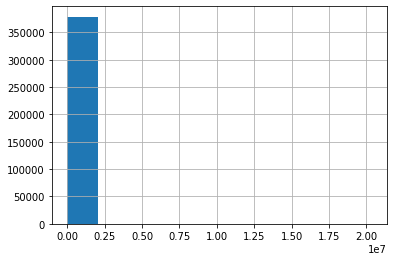

In [98]:
%matplotlib inline
kickstarter_2018.usd_pledged.hist();  # histograma de lo recaudado

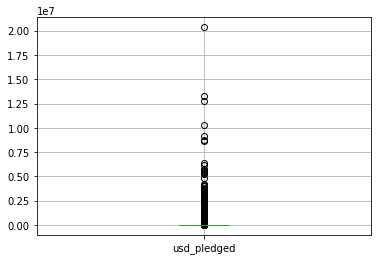

In [100]:
kickstarter_2018.boxplot(column='usd_pledged');  # gráfico de boxplot de lo recaudado para observar outliers

"There are many rules of thumb for how to define an outlier but there is no silver bullet. One rule of thumb is that any data point that is three standard deviations away from the mean of the same data point for all observations."

In [99]:
outliers = kickstarter_2018[kickstarter_2018.usd_pledged > (kickstarter_2018.usd_pledged.mean() + 
                                                            3 * kickstarter_2018.usd_pledged.std())]
# cálculo los ourliers, es decir outliers serán aquellos mayores a la media más la() desviación estándar *3) de lo recaudado
outliers

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
154,1000629643,ODIN: Android 'Smart' Projector to Carry in Yo...,Hardware,Technology,Technology,2014-07-08,250000.00,2014-05-28 13:54:18,268192.00,successful,561,US,268192.00,268192.00,250000.00,0
175,1000725978,"Air Bonsai | Create your ""little star""",Product Design,Design,Technology,2016-03-01,80000.00,2016-01-21 12:18:00,843743.00,successful,3784,US,843743.00,843743.00,80000.00,0
330,1001502333,Pimax: The World's First 8K VR Headset,Hardware,Technology,Technology,2017-11-03,200000.00,2017-09-19 19:02:23,4236618.49,successful,5946,US,608194.00,4236618.49,200000.00,0
655,1003182869,RinseKit: The Revolutionary Portable Shower,Gadgets,Technology,Technology,2016-06-03,30000.00,2016-05-04 19:27:57,396299.00,successful,2412,US,396299.00,396299.00,30000.00,0
1185,1006008989,War for the Overworld,Video Games,Games,Fashion,2013-01-03,150000.00,2012-11-29 19:11:23,211371.50,successful,8351,GB,338527.51,338589.87,240280.65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377620,994834878,KP Duffle - The Ultimate Travel Bag,Product Design,Design,Technology,2016-03-04,15000.00,2016-01-19 17:00:36,624474.00,successful,3478,US,624474.00,624474.00,15000.00,0
377699,995248054,LYFE - Set your plants free,Product Design,Design,Technology,2016-07-01,80000.00,2016-06-01 18:53:37,328579.00,successful,1203,US,328579.00,328579.00,80000.00,0
377761,995551135,Infinity: Battlescape,Video Games,Games,Technology,2015-11-20,300000.00,2015-10-21 13:34:08,332620.81,successful,5828,US,332620.81,332620.81,300000.00,0
378084,997256071,SoftPanels LED Lights with Intelligent/Precise...,Camera Equipment,Technology,Technology,2016-05-08,30000.00,2016-04-08 22:18:23,394930.00,successful,213,US,394930.00,394930.00,30000.00,0


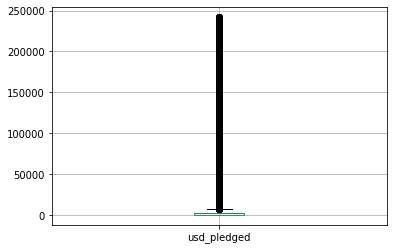

In [101]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd_pledged');  # gráfico de boxplot sin valores nulos para el valor recaudado

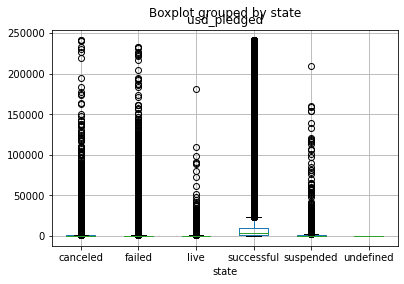

In [102]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd_pledged',by='state'); # gráfico de

Analizar outliers por categorías

In [ ]:
kickstarter_2018.boxplot(column='usd_pledged',by='state');
kickstarter_2018.boxplot(column='usd_goal_real',by='state');

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
29,100011318,My Moon - Animated Short Film,Animation,Film & Video,Technology,2017-05-03,50000.00,2017-04-03 17:11:33,57577.31,successful,840,US,10120.00,57577.31,50000.00,0
32,1000120151,Feather Cast Furled Fly Fishing Leaders,Product Design,Design,Art,2015-08-22,2000.00,2015-07-23 03:09:43,2000.00,successful,18,AU,1473.62,1427.35,1427.35,0
41,1000153208,Phil Younger - Slow Down (Official Music Video),Music,Music,Technology,2016-12-20,2100.00,2016-12-09 20:27:02,2100.00,successful,34,US,83.00,2100.00,2100.00,0
102,1000415969,Disaster Area: A Podcast,Radio & Podcasts,Publishing,Technology,2016-12-28,1000.00,2016-11-28 17:58:04,1055.00,successful,19,US,0.00,1055.00,1000.00,0
116,1000490852,Carriage,Art,Art,Technology,2017-12-24,8000.00,2017-11-24 18:06:35,8360.00,successful,121,US,605.00,8360.00,8000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378567,999499675,Truly Gently presents Theatorium,Animation,Film & Video,Comics,2013-12-12,5000.00,2013-11-15 15:59:13,5140.00,successful,58,CA,4907.96,4824.03,4692.63,0
378636,999877902,Little Saturday's Debut Album,Country & Folk,Music,Comics,2014-12-17,5000.00,2014-11-17 17:50:12,5435.00,successful,78,CA,4814.88,4686.96,4311.83,0
378637,999878813,Ways to Look at the Moon,Shorts,Film & Video,Technology,2017-10-13,10000.00,2017-08-29 06:57:28,10245.00,successful,123,US,145.00,10245.00,10000.00,0
378642,999929142,ÉPOUVANTAILS : 28mm Figurines de jeux pour KIN...,Tabletop Games,Games,Design,2017-10-31,1000.00,2017-10-04 11:26:44,1246.00,successful,35,FR,66.72,1452.47,1165.70,0


#### Ejercicio 6

Calcular los valores atípicos de 'usd_goal_real' y graficar los boxplots, con y sin estos valores por categoría

In [ ]:
kickstarter_2018[(kickstarter_2018.state == 'succesfull') & (kickstarter_2018.usd_pledged < goal)] 

## 2.7. Evaluar cómo comprimir los datos 
para su almacenamiento más eficiente.

En la actualidad, en las nubes el almacenamiento no suele ser problema sino la velocidad para leerlo que suele ser determinante a la hora de determinar el formato de almacenamiento.


## 2.8. Guardar el set de datos con un nombre informativo.


EL problema de la ingeniería de software